In [16]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder

# Load your dataset and split it into features (X) and target (y)
stroke_df = pd.read_csv("healthcare-dataset-stroke-data.csv")
stroke_df

stroke_df.drop(columns=['bmi'], inplace=True)

class MultiColumnLabelEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.encoders = {}
        for column in X.columns:
            le = LabelEncoder()
            le.fit(X[column].astype(str))
            self.encoders[column] = le
        return self
    
    def transform(self, X, y=None):
        X_copy = X.copy()
        for column, encoder in self.encoders.items():
            X_copy[column] = encoder.transform(X_copy[column].astype(str))
        return X_copy
    
encoder = MultiColumnLabelEncoder()
stroke_encoded = encoder.fit_transform(stroke_df)
stroke_encoded



,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,smoking_status,stroke
0,5053,1,85,0,1,1,2,1,1618,1,1
1,3218,0,79,0,0,1,3,0,1356,2,1
2,1593,1,100,0,1,1,2,0,251,2,1
3,3907,0,65,0,0,1,2,1,1153,3,1
4,530,0,98,1,0,1,3,0,1162,2,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,652,0,100,1,0,1,2,1,3107,2,0
5106,2641,0,101,0,0,1,3,1,798,2,0
5107,745,0,50,0,0,1,3,0,3061,2,0
5108,2105,1,68,0,0,1,2,0,1131,1,0


In [17]:
# Feature selection
X = stroke_encoded[['age', 'work_type', 'Residence_type']]
y = stroke_encoded['stroke']

# This step we are splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# This following step is fitting the KNN model with the training data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# Selecting an age range from 15-85, progressively scaling by increments of 5
ages = range(15, 85, 5)  

# Now we are creating a DataFrame with combination of the features" age, residence type, and work type)
input_data = []
for age in ages:
    for residence_type in range(2):  # Assuming 0 for urban and 1 for rural
        for work_type in range(5):  # Assuming 0 to 5 for different work types
            input_data.append({'age': age, 'Residence_type': residence_type, 'work_type': work_type})

input_df = pd.DataFrame(input_data)

input_df = input_df[['age', 'work_type', 'Residence_type']]

# An additional level of scaling for this dataset since we're only working with three features
input_scaled = scaler.transform(input_df)

# Predictions using the trained KNN model
probabilities = knn.predict_proba(input_scaled)[:, 1]  # Predict probability of stroke (class 1)

# We are now adding the prediction of stroke probability to these three selected features
input_df['stroke_probability'] = probabilities

print(input_df)


     age  work_type  Residence_type  stroke_probability
0     15          0               0                 0.0
1     15          1               0                 0.0
2     15          2               0                 0.0
3     15          3               0                 0.0
4     15          4               0                 0.0
..   ...        ...             ...                 ...
135   80          0               1                 0.0
136   80          1               1                 0.0
137   80          2               1                 0.0
138   80          3               1                 0.0
139   80          4               1                 0.0

[140 rows x 4 columns]


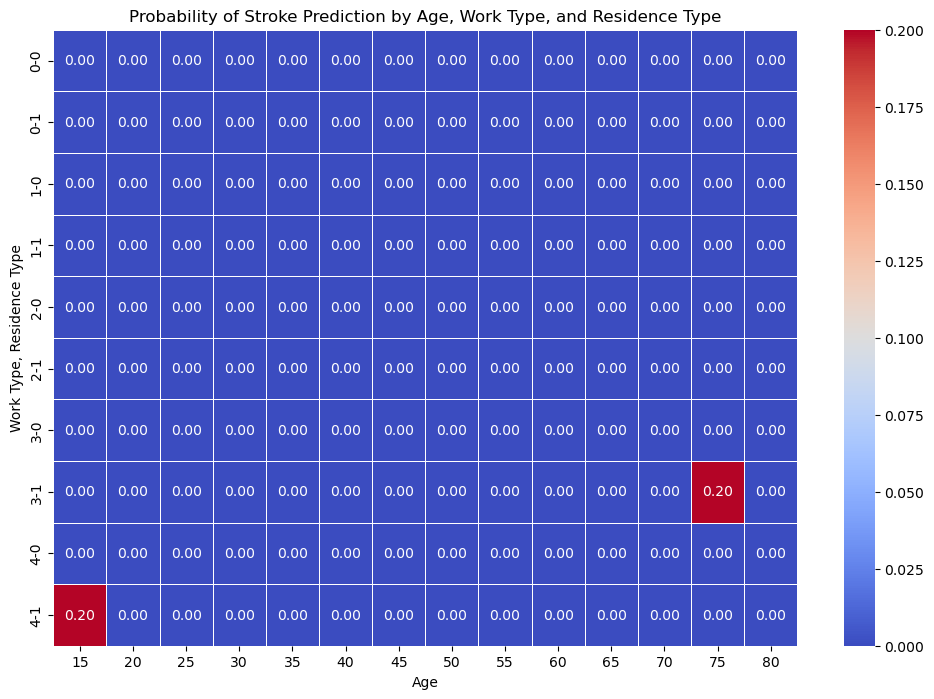

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# This step is to reshape the input DataFrame to a pivot table for heatmap
input_df.drop_duplicates(subset=['work_type', 'age', 'Residence_type'], inplace=True)
heatmap_data = input_df.pivot_table(index=['work_type', 'Residence_type'], columns='age', values='stroke_probability')

# Coding for our heatmap to include all three features with Age as our x-axis
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.title('Probability of Stroke Prediction by Age, Work Type, and Residence Type')
plt.xlabel('Age')
plt.ylabel('Work Type, Residence Type')
plt.show()
